In [1]:
# DeepChem imports
import deepchem
from deepchem.molnet import *
# Transformers imports
from transformers import (
    AutoModelForMaskedLM, AutoTokenizer, RobertaModel, RobertaTokenizer, RobertaTokenizerFast,
    RobertaConfig, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer,
    pipeline
)
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.trainer_pt_utils import get_parameter_names

# Torch imports
import torch
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader

# Accelerate
from accelerate import Accelerator

# Other libraries
import rdkit
from rdkit import Chem
import numpy as np
import pandas as pd
import random
from random import random
from datasets import Dataset
import sklearn
from sklearn.metrics import root_mean_squared_error, roc_auc_score,mean_squared_error
import ipynbname
from typing import List, Optional, Union, Tuple
import os
import sys
import bitsandbytes as bnb



No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\Users\Kamen\anaconda3\envs\Work2\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
def get_notebook_name():
    try:
        return ipynbname.name()
    except Exception:
        return "unknown_notebook"

# Get the notebook's name
notebook_name = get_notebook_name().split(".")[0]  # Remove file extension if any
notebook_name = get_notebook_name().split(".")[0] 
os.makedirs("result_graphs", exist_ok=True)

In [3]:
#model_pth = "seyonec/PubChem10M_SMILES_BPE_450k"
#model_pth = "C:/Users/V/Anaconda Notebooks/Paracelsus_Main/GrandBookData/ChemBERTa-77M-MLM"
model_pth = "./GrandBookData/PubchemModel"
model_pth2 = "./GrandBookData/MediumProtein/ProteinModel"

In [4]:
class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_labels):
        super().__init__()
        self.dense = nn.Linear(4*config.hidden_size, config.hidden_size)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(config.hidden_size, num_labels)

    def forward(self, features, **kwargs):
        #x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class RobertaMultiTaskModel(RobertaPreTrainedModel):
    def __init__(self, model_path1, model_path2, num_labels_list, problem_type_list):
        """
        Args:
        - config: Model configuration.
        - num_labels_list: A list where each element represents the number of labels for a specific task.
        """
        config = AutoConfig.from_pretrained(model_path1)
        super().__init__(config)
        self.config = config
        self.config2 = AutoConfig.from_pretrained(model_path2)

        # Two separate encoders
        self.encoder1 = RobertaModel.from_pretrained(model_path1, add_pooling_layer=False)
        self.encoder2 = RobertaModel.from_pretrained(model_path1, add_pooling_layer=False)
        self.encoder3 = RobertaModel.from_pretrained(model_path2, add_pooling_layer=False)
        self.encoder4 = RobertaModel.from_pretrained(model_path2, add_pooling_layer=False)

        for param in self.encoder1.parameters():
            param.requires_grad = False
        
        # Task-specific classification heads
        self.hidden_size = config.hidden_size
        self.num_tasks = len(num_labels_list)
        self.classification_heads = nn.ModuleList(
            [RobertaClassificationHead(config, num_labels=num_labels) 
             for num_labels in num_labels_list]
        )

        # Number of labels for each task
        self.num_labels_list = num_labels_list
        self.problem_type_list = problem_type_list
        # Initialize weights
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        input_ids2: Optional[torch.LongTensor] = None,
        attention_mask2: Optional[torch.FloatTensor] = None,
        input_ids3: Optional[torch.LongTensor] = None,
        attention_mask3: Optional[torch.FloatTensor] = None,
        labels_list: Optional[list] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], dict]:
        """
        Args:
        - input_ids1, attention_mask1: Inputs for the first encoder.
        - input_ids2, attention_mask2: Inputs for the second encoder.
        - labels_list: List of labels for each task.
        - return_dict: Whether to return a dictionary or a tuple.

        Returns:
        - A dictionary or tuple containing task-specific logits and optional losses.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # First encoder forward pass
        outputs1 = self.encoder1(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        pooled_output1 = outputs1.last_hidden_state[:, 0, :]  # [CLS] token

                        # First encoder forward pass
        outputs2 = self.encoder2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        pooled_output2 = outputs2.last_hidden_state[:, 0, :]  # [CLS] token
        
        # Second encoder forward pass (if provided)
        if input_ids2 is not None and attention_mask2 is not None:
            outputs3 = self.encoder3(
                input_ids=input_ids2,
                attention_mask=attention_mask2,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
            pooled_output3 = outputs3.last_hidden_state[:, 0, :]  # [CLS] token
        else:
            pooled_output3 = torch.zeros_like(outputs1.last_hidden_state[:, 0, :])  # Provide zeros if no input to encoder2

                # Second encoder forward pass (if provided)
        if input_ids3 is not None and attention_mask3 is not None:
            outputs4 = self.encoder4(
                input_ids=input_ids3,
                attention_mask=attention_mask3,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
            pooled_output4 = outputs4.last_hidden_state[:, 0, :]  # [CLS] token
        else:
            pooled_output4 = torch.zeros_like(outputs1.last_hidden_state[:, 0, :])  # Provide zeros if no input to encoder2


        
        # Combine outputs (e.g., concatenate)
        combined_output = torch.cat((pooled_output1, pooled_output2,pooled_output3,pooled_output4), dim=1)
        
        # Compute task-specific logits
        logits_list = [head(combined_output) for head in self.classification_heads]

        # Compute task-specific losses
        losses = []
        if labels_list is not None:
            for i, labels in enumerate(labels_list):
                if labels is not None:
                    problem_type = self.problem_type_list[i]
                    labels = labels.to(logits_list[i].device)
                    num_labels = self.num_labels_list[i]
                    if problem_type == "regression":  # Regression task
                        loss_fct = MSELoss()
                        if num_labels == 1:
                            loss = loss_fct(logits_list[i].squeeze(), labels.squeeze())
                        else:
                            loss = loss_fct(logits_list[i], labels)
                    elif problem_type == "single_label_classification":  # Single-label classification
                        loss_fct = CrossEntropyLoss()
                        loss = loss_fct(logits_list[i].view(-1, num_labels), labels.view(-1))
                    elif problem_type == "multi_label_classification":  # Multi-label classification
                        loss_fct = BCEWithLogitsLoss()
                        loss = loss_fct(logits_list[i], labels)
                    else:
                        print("ERROR. UNKNOWN PROBLEM TYPE")
                        print("LOSS IS ZERO, PROVIDE PROBLEM TYPE AS INPUT")
                        loss = torch.zeros(1)
                    losses.append(loss)

        # Return output
        if not return_dict:
            return logits_list if not losses else (sum(losses), logits_list)

        return {
            "loss": sum(losses) if losses else None,
            "logits": logits_list,
            "hidden_states": [outputs1.hidden_states, outputs2.hidden_states],
            "attentions": [outputs1.attentions, outputs2.attentions],
        }


In [5]:
# Unified task and dataset details
Datasets_Available = {
    "bace": {"load_fn": load_bace_classification,"problem_type": "multi_label_classification", "num_labels": 1},
    "hiv": {"load_fn": load_hiv,"problem_type": "multi_label_classification", "num_labels": 1},
    "bbbp": {"load_fn": load_bbbp,"problem_type": "multi_label_classification", "num_labels": 1},
    "clintox": {"load_fn": load_clintox,"problem_type": "multi_label_classification", "num_labels": 2},
    "tox21": {"load_fn": load_tox21,"problem_type": "multi_label_classification","num_labels": 12},
    "muv": {"load_fn": load_muv,"problem_type": "multi_label_classification", "num_labels": 17},
    "sider": {"load_fn": load_sider,"problem_type": "multi_label_classification", "num_labels": 27},
    "toxcast": {"load_fn": load_toxcast,"problem_type": "multi_label_classification", "num_labels": 617},
    "delaney": {"load_fn": load_delaney, "problem_type": "regression", "num_labels": 1},
    "freesolv": {"load_fn": load_freesolv, "problem_type": "regression", "num_labels": 1},
    "lipo": {"load_fn": load_lipo, "problem_type": "regression", "num_labels": 1},
}

num_labels_list = [value["num_labels"] for value in Datasets_Available.values()]
problem_type_list = [value["problem_type"] for value in Datasets_Available.values()]
model = RobertaMultiTaskModel(model_pth, model_pth2, num_labels_list,problem_type_list)
model
print(model)
# Load tokenizer and datasets
tokenizer = AutoTokenizer.from_pretrained(model_pth)
tokenizer2 = AutoTokenizer.from_pretrained(model_pth2)

print("Model, tokenizer, and datasets initialized successfully!")
tokenizer


RobertaMultiTaskModel(
  (encoder1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(2692, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-3): 4 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

RobertaTokenizerFast(name_or_path='./GrandBookData/PubchemModel', vocab_size=2692, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [6]:
for param in model.parameters():
    print(param.size(),param.requires_grad)

torch.Size([2692, 768]) False
torch.Size([514, 768]) False
torch.Size([1, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([3072, 768]) False
torch.Size([3072]) False
torch.Size([768, 3072]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([3072, 768]) False
torch.Size([3072]) False
torch.Size([768, 3072]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
tor

In [7]:
tokenizer2

RobertaTokenizerFast(name_or_path='./GrandBookData/MediumProtein/ProteinModel', vocab_size=5590, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [8]:
# Example inputs
np.random.seed(41)
y = np.random.randint(0, 2, size=(10, 3))  # Multilabel target matrix (1480 samples, 5 labels)
w = np.random.rand(10, 3)  # Old weights (same shape as y)
w[w < 0.2] = 0  # Simulating some zero weights

def fix_weights(y,w):
    # Identify valid rows where the old weight is non-zero
    valid_mask = w != 0
    
    # Initialize new weights array
    new_w = np.zeros_like(w, dtype=float)

    dropped_labels_ids = []
    
    # Compute scaled weights for each label (column)
    for j in range(y.shape[1]):
        valid_entries = valid_mask[:, j]
        valid_y = y[valid_entries, j]
    
        # Count positives and negatives
        num_positives = np.sum(valid_y == 1)
        num_negatives = np.sum(valid_y == 0)

        if y.shape[1]>1 and (num_positives * num_negatives==0):
            print("Bad label", j)
            dropped_labels_ids.append(j)
        else:
            # Scale weights to ensure the smallest value is 1
            max_count = max(num_positives, num_negatives)
            weight_for_1 = max_count / (num_positives or 1)
            weight_for_0 = max_count / (num_negatives or 1)
            scale_factor = min(weight_for_1, weight_for_0)  # Scale to make the smallest weight 1
        
            # Assign weights
            new_w[valid_entries, j] = np.where(valid_y == 1, weight_for_1 / scale_factor, weight_for_0 / scale_factor)

    return new_w, dropped_labels_ids

fix_weights(y,w)

(array([[0.        , 1.66666667, 2.33333333],
        [1.        , 1.        , 1.        ],
        [1.66666667, 1.66666667, 1.        ],
        [1.66666667, 1.        , 1.        ],
        [1.        , 0.        , 1.        ],
        [0.        , 0.        , 2.33333333],
        [1.        , 1.        , 2.33333333],
        [1.66666667, 1.66666667, 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]]),
 [])

In [9]:
import random
def mask_string(s, n):
    """
    Masks n% of the characters in the string 's'.
    Alphabet characters (both uppercase and lowercase) are replaced with 'X',
    other chars (non-alphabetic) are replaced with '~'.
    """
    # List of the characters in the string for mutability
    masked_s = list(s)
    total_chars = len(s)
    
    # Calculate how many characters we need to mask (n% of the total characters)
    num_to_mask = max(1, int(total_chars * n / 100))  # Ensure at least one character is masked
    multiplier = (1-num_to_mask/total_chars)**3
    # Randomly select indices to mask
    indices_to_mask = random.sample(range(total_chars), num_to_mask)
    
    for idx in indices_to_mask:
        if s[idx].isalpha():  # If the character is an alphabetic letter
            masked_s[idx] = 'X'
        else:  # If it's not an alphabetic character
            masked_s[idx] = '~'

    return ''.join(masked_s), multiplier

def extend_dataset(strings, maxn, k, labels = [], weights=[]):
    """
    Extends the dataset by creating k masked versions for each string,
    plus the original string, with n% characters masked.
    """
    extended_dataset = []
    extended_dataset_labels = []
    extended_weights = []
    for i in range(len(strings)):
        s = strings[i]
        w = weights[i]
        extended_dataset.append(s)  # Add the original string
        extended_weights.append(w)
        if len(labels)==len(strings):
            extended_dataset_labels.append(labels[i])
        for _ in range(k-1):
            n = random.randint(5, maxn)
            new_string, multiplier = mask_string(s, n)
            #print(n, multiplier)
            extended_dataset.append(new_string)  # Add a masked version
            extended_weights.append(w*multiplier)  # Add a masked version
            if len(labels)==len(strings):
                extended_dataset_labels.append(labels[i])
    print("Extended from",len(strings),"to",len(extended_dataset))
    print("Example", extended_dataset[:3])
    print("Example", extended_weights[:3])
    return extended_dataset, extended_dataset_labels, extended_weights

# Example usage
original_strings = ["Hello World!", "CC(C)(C)C1=CC(=C(C=C1NC(=O)", "Test 123"]
weights = [4.16, 3.81, 2.75]
labels = [1, 0, 1]
maxn = 30
k = 3

# Test the function
extended_dataset, extended_dataset_labels, extended_weights = extend_dataset(
    original_strings, maxn, k, labels, weights
)

# Print the results
print("\nExtended Strings:", extended_dataset)
print("\nExtended Labels:", extended_dataset_labels)
print("\nExtended Weights:", extended_weights)

Extended from 3 to 9
Example ['Hello World!', 'Hello~World!', 'Xello World~']
Example [4.16, 3.204259259259259, 2.407407407407408]

Extended Strings: ['Hello World!', 'Hello~World!', 'Xello World~', 'CC(C)(C)C1=CC(=C(C=C1NC(=O)', 'CC(X)(C)C1=CC(=C~C=C1XC~=O~', 'CC(C)(C)C1=CX(=C(C=C1NC~~O~', 'Test 123', 'Test ~23', 'Test~123']

Extended Labels: [1, 1, 1, 0, 0, 0, 1, 1, 1]

Extended Weights: [4.16, 3.204259259259259, 2.407407407407408, 3.81, 2.0611126352690143, 2.355142508763908, 2.75, 1.84228515625, 1.84228515625]


In [10]:
def dataset_extractor(dataset, task_type,tasks, prototyping = False, extend_data = False):
    dataset_parts = []
    i = 0
    for data in dataset:
        molecules_text = [Chem.MolToSmiles(molecule, isomericSmiles=True, canonical = True) for molecule in data.X]
        
        #print(molecules_text[:3])
        target_labels = data.y.astype(float)
        
        new_w, dropped_labels_ids = fix_weights(target_labels, data.w )
        print(len(molecules_text))
        print(len(target_labels))
        print(len(new_w))
        if i ==0:
            if extend_data:
                max_train_size = 74470
                extending_coefficient = max_train_size//len(molecules_text)
                extending_percentage = 15
                if extending_coefficient>1:
                    molecules_text,target_labels,new_w = extend_dataset(molecules_text,extending_percentage,extending_coefficient,target_labels,new_w)
                    print(len(molecules_text))
                    print(len(target_labels))
                    print(len(new_w))
            if len(dropped_labels_ids)>0:
                dropped_tasks = tasks[dropped_labels_ids]
                print("____________________")
                print("____________________")
                print("Removed bad tasks with 1 class instead of 2 required after cleaning NaN")
                print(dropped_tasks)
                print("____________________")
                print("____________________")
                target_labels = np.delete(target_labels, dropped_labels_ids, axis=1)
                tasks = np.delete(tasks, dropped_labels_ids)
    
            #if task_type == "regression":
                #target_labels = data.y.astype(float)
            #else:
                #target_labels = data.y.astype(int)
            i+=1
        if prototyping and len(molecules_text)>1000:
            part = int(len(molecules_text)/10)
            dataset_parts.append(Dataset.from_dict({"text": molecules_text[:part], "labels": target_labels[:part], "weights": new_w[:part]}) )
        else:
            dataset_parts.append(Dataset.from_dict({"text": molecules_text, "labels": target_labels, "weights": new_w}) )
        
    return dataset_parts, tasks

In [11]:
def tokenization(example):
    #print(len(example["text"]))
    return tokenizer(example["text"],padding='max_length', truncation=True, max_length=512)

In [12]:
#target_datasets = ["clintox","bbbp", "lipo"]
target_datasets = list(Datasets_Available.keys())
prototyping = False
extend = False
stratifiedsplitter = deepchem.splits.RandomStratifiedSplitter()
simplesplitter = deepchem.splits.RandomSplitter()
#target_datasets = list(Datasets_Available.keys())
loaded_datasets = {}
for dataset_name in target_datasets:
    dataset_config = Datasets_Available[dataset_name]
    dataset_dc = dataset_config["load_fn"](featurizer="Raw",reload=False,split = None)
    #if "tasks_wanted" in dataset_config:
    tasks, dataset, transformers = dataset_dc
    #print(dataset)
    if dataset_config["problem_type"] == "regression":
        dataset = simplesplitter.train_test_split(dataset[0])
        #dataset = simplesplitter.train_valid_test_split(dataset[0])
    else:
        dataset = stratifiedsplitter.train_test_split(dataset[0])
        #dataset = stratifiedsplitter.train_valid_test_split(dataset[0])
    print(dataset_name)
    print(dataset)
    [train, test], tasks = dataset_extractor(dataset,dataset_config["problem_type"],tasks,prototyping,extend)
    #[train,valid, test], tasks = dataset_extractor(dataset,dataset_config["dataset_type"],tasks,prototyping)
    train = train.map(tokenization, batched=True)
    test = test.map(tokenization, batched=True)
    #valid = valid.map(tokenization, batched=True)
    loaded_dataset = {"train":train, "test":test, "tasks": tasks}
    #loaded_dataset = {"train":train, "test":test, "valid":valid, "tasks": tasks}
    loaded_datasets[dataset_name] = loaded_dataset
    

'split' is deprecated.  Use 'splitter' instead.


bace
(<DiskDataset X.shape: (np.int64(1210),), y.shape: (np.int64(1210), np.int64(1)), w.shape: (np.int64(1210), np.int64(1)), task_names: ['Class']>, <DiskDataset X.shape: (np.int64(303),), y.shape: (np.int64(303), np.int64(1)), w.shape: (np.int64(303), np.int64(1)), ids: ['Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(=O)C)(CC(C)C)C1=O)CCc1ccccc1)[C@H](O)[C@@H]1[NH2+]C[C@H](OCCC)C1'
 'S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(F)(F)F)Cc1ccccc1)C'
 'Fc1cc(cc(F)c1)C[C@H](NC(=O)c1cc(cc(c1)C)C(=O)N(CCC)CCC)[C@H](O)[C@@H]1[NH2+]CCN(Cc2ccccc2)C1=O'
 ... 'Clc1cc2nc(n(c2cc1)CCCC(=O)NCc1ncccc1)N'
 '[nH]1nnnc1C(NC1=NC(Cc2c1cccc2)(C)C)Cc1ccccc1'
 'Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N'], task_names: ['Class']>)
1210
1210
1210
303
303
303


Map:   0%|          | 0/1210 [00:00<?, ? examples/s]

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[15:59:25] WARNING: not removing hydrogen atom without neighbors
[15:59:25] WARNING: not removing hydrogen atom without neighbors


hiv
(<DiskDataset X.shape: (np.int64(32902),), y.shape: (np.int64(32902), np.int64(1)), w.shape: (np.int64(32902), np.int64(1)), task_names: ['HIV_active']>, <DiskDataset X.shape: (np.int64(8225),), y.shape: (np.int64(8225), np.int64(1)), w.shape: (np.int64(8225), np.int64(1)), task_names: ['HIV_active']>)
32902
32902
32902
8225
8225
8225


Map:   0%|          | 0/32902 [00:00<?, ? examples/s]

Map:   0%|          | 0/8225 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[15:59:40] Explicit valence for atom # 1 N, 4, is greater than permitted
Failed to featurize datapoint 59, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[15:59:40] WARNING: not removing hydrogen atom without neighbors
[15:59:40] Explicit valence for atom # 6 N, 4, is greater than permitted
Failed to featurize datapoint 61, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=

bbbp
(<DiskDataset X.shape: (np.int64(1631),), y.shape: (np.int64(1631), np.int64(1)), w.shape: (np.int64(1631), np.int64(1)), task_names: ['p_np']>, <DiskDataset X.shape: (np.int64(408),), y.shape: (np.int64(408), np.int64(1)), w.shape: (np.int64(408), np.int64(1)), ids: ['CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)c4c(O)cccc4[C@@]3(C)O)C(=O)[C@]2(O)C(=O)\\C(=C(/O)NCN5CCCC5)C1=O'
 'C1N(C(CC2CCCCC12)C(NC(C)(C)C)=O)CC(C(Cc1ccccc1)NC(C(NC(c1nc2c(cccc2)cc1)=O)CC(N)=O)=O)O'
 'CCCC(C)C' ... 'C1=C(OC)C=CC2=NC=CC(=C12)CCCC3C(CNCC3)C=C'
 'C3=C(C1=NCCN=C2N(NC(=C12)C)C)C=CC=C3Cl'
 '[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=CC=C3)C'], task_names: ['p_np']>)
1631
1631
1631
408
408
408


Map:   0%|          | 0/1631 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[15:59:41] Explicit valence for atom # 0 N, 5, is greater than permitted
Failed to featurize datapoint 7, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[15:59:41] Can't kekulize mol.  Unkekulized atoms: 9
Failed to featurize datapoint 302, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[15:59:42] Can't kekulize mol.  Unkekulized atoms: 4
Failed to featurize datap

clintox
(<DiskDataset X.shape: (np.int64(1187),), y.shape: (np.int64(1187), np.int64(2)), w.shape: (np.int64(1187), np.int64(2)), task_names: ['FDA_APPROVED' 'CT_TOX']>, <DiskDataset X.shape: (np.int64(293),), y.shape: (np.int64(293), np.int64(2)), w.shape: (np.int64(293), np.int64(2)), ids: ['[H]/[NH+]=C(/C1=CC(=O)/C(=C\\C=c2ccc(=C([NH3+])N)cc2)/C=C1)\\N'
 'B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C2=NC=CN=C2)(O)O'
 'C#CC[NH2+][C@@H]1CCc2c1cccc2' ... 'COc1cnc(nc1)[N-]S(=O)(=O)c2ccc(cc2)N'
 'COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC.Cl' 'O=[Ti]=O'], task_names: ['FDA_APPROVED' 'CT_TOX']>)
1187
1187
1187
293
293
293


Map:   0%|          | 0/1187 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[15:59:42] WARNING: not removing hydrogen atom without neighbors


tox21
(<DiskDataset X.shape: (np.int64(6265),), y.shape: (np.int64(6265), np.int64(12)), w.shape: (np.int64(6265), np.int64(12)), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>, <DiskDataset X.shape: (np.int64(1566),), y.shape: (np.int64(1566), np.int64(12)), w.shape: (np.int64(1566), np.int64(12)), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>)
6265
6265
6265
1566
1566
1566


Map:   0%|          | 0/6265 [00:00<?, ? examples/s]

Map:   0%|          | 0/1566 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.


muv
(<DiskDataset X.shape: (np.int64(74470),), y.shape: (np.int64(74470), np.int64(17)), w.shape: (np.int64(74470), np.int64(17)), task_names: ['MUV-466' 'MUV-548' 'MUV-600' ... 'MUV-852' 'MUV-858' 'MUV-859']>, <DiskDataset X.shape: (np.int64(18617),), y.shape: (np.int64(18617), np.int64(17)), w.shape: (np.int64(18617), np.int64(17)), task_names: ['MUV-466' 'MUV-548' 'MUV-600' ... 'MUV-852' 'MUV-858' 'MUV-859']>)
74470
74470
74470
18617
18617
18617


Map:   0%|          | 0/74470 [00:00<?, ? examples/s]

Map:   0%|          | 0/18617 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors
[16:00:36] WARNING: not removing hydrogen atom without neighbors


sider
(<DiskDataset X.shape: (np.int64(1141),), y.shape: (np.int64(1141), np.int64(27)), w.shape: (np.int64(1141), np.int64(27)), task_names: ['Hepatobiliary disorders' 'Metabolism and nutrition disorders'
 'Product issues' ... 'Cardiac disorders' 'Nervous system disorders'
 'Injury, poisoning and procedural complications']>, <DiskDataset X.shape: (np.int64(286),), y.shape: (np.int64(286), np.int64(27)), w.shape: (np.int64(286), np.int64(27)), ids: ['CCCCCCOC(=O)N=C(C1=CC=C(C=C1)NCC2=NC3=C(N2C)C=CC(=C3)C(=O)N(CCC(=O)OCC)C4=CC=CC=N4)N'
 'C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C(=O)NC(CCC(=O)O)C(=O)O'
 'CC(=O)[O-]' ... 'C1(=C(N=C(C(=N1)Cl)N)N)C(=O)N=C(N)N.Cl'
 'CC[C@@H]1[C@@]2([C@@H]([C@@H](C(=O)[C@@H](C[C@@]([C@@H]([C@H](C(=O)[C@H](C(=O)O1)C)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)OC)C)C)N(C(=O)O2)CCCCN4C=C(N=C4)C5=CN=CC=C5)C'
 'C1CN(CCC1N2C3=CC=CC=C3NC2=O)CCCC(C4=CC=C(C=C4)F)C5=CC=C(C=C5)F'], task_names: ['Hepatobiliary disorders' 'Metabolism and nutrition disorders'
 'Produ

Map:   0%|          | 0/1141 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[16:00:38] Explicit valence for atom # 0 F, 2, is greater than permitted
Failed to featurize datapoint 1039, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[16:00:38] Explicit valence for atom # 2 Cl, 2, is greater than permitted
Failed to featurize datapoint 1789, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[16:00:38] Explicit valence for atom # 0 Cl, 2, is gr

toxcast
(<DiskDataset X.shape: (np.int64(6862),), y.shape: (np.int64(6862), np.int64(617)), w.shape: (np.int64(6862), np.int64(617)), task_names: ['ACEA_T47D_80hr_Negative' 'ACEA_T47D_80hr_Positive'
 'APR_HepG2_CellCycleArrest_24h_dn' ... 'Tanguay_ZF_120hpf_TRUN_up'
 'Tanguay_ZF_120hpf_TR_up' 'Tanguay_ZF_120hpf_YSE_up']>, <DiskDataset X.shape: (np.int64(1715),), y.shape: (np.int64(1715), np.int64(617)), w.shape: (np.int64(1715), np.int64(617)), task_names: ['ACEA_T47D_80hr_Negative' 'ACEA_T47D_80hr_Positive'
 'APR_HepG2_CellCycleArrest_24h_dn' ... 'Tanguay_ZF_120hpf_TRUN_up'
 'Tanguay_ZF_120hpf_TR_up' 'Tanguay_ZF_120hpf_YSE_up']>)
6862
6862
6862
1715
1715
1715


Map:   0%|          | 0/6862 [00:00<?, ? examples/s]

Map:   0%|          | 0/1715 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.


delaney
(<DiskDataset X.shape: (np.int64(902),), y.shape: (np.int64(902), np.int64(1)), w.shape: (np.int64(902), np.int64(1)), ids: ['CCSCCSP(=S)(OC)OC' 'Clc1c(Cl)c(Cl)c(N(=O)=O)c(Cl)c1Cl'
 'CCNc1nc(NC(C)C)nc(SC)n1' ...
 'COP(=S)(OC)Oc1ccc(Sc2ccc(OP(=S)(OC)OC)cc2)cc1' 'CCCC' 'CCCOC=O'], task_names: ['measured log solubility in mols per litre']>, <DiskDataset X.shape: (np.int64(226),), y.shape: (np.int64(226), np.int64(1)), w.shape: (np.int64(226), np.int64(1)), ids: ['NC(=O)N' 'CCO' 'COC1=CC(=O)CC(C)C13Oc2c(Cl)c(OC)cc(OC)c2C3=O' ...
 'CC(C)c1ccccc1C' 'OC(C(=O)c1ccccc1)c2ccccc2'
 'c1ccc2c3c(ccc2c1)c4cccc5cccc3c45'], task_names: ['measured log solubility in mols per litre']>)
902
902
902
226
226
226


C:\Users\Kamen\AppData\Local\Temp\ipykernel_14340\2352499986.py:36: RuntimeWarning: invalid value encountered in scalar divide
  new_w[valid_entries, j] = np.where(valid_y == 1, weight_for_1 / scale_factor, weight_for_0 / scale_factor)


Map:   0%|          | 0/902 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.


freesolv
(<DiskDataset X.shape: (np.int64(513),), y.shape: (np.int64(513), np.int64(1)), w.shape: (np.int64(513), np.int64(1)), ids: ['C1CCOC1' 'CC(C)(C)C' 'COc1c(cc(c(c1O)OC)Cl)Cl' ... 'c1ccc2c(c1)cccc2O'
 'CC(OC(=O)C)OC(=O)C' 'CCCCCCC'], task_names: ['y']>, <DiskDataset X.shape: (np.int64(129),), y.shape: (np.int64(129), np.int64(1)), w.shape: (np.int64(129), np.int64(1)), ids: ['CCCSCCC' 'CCN' 'CCC(=O)OC' ... 'Cc1cccc(c1N)C' 'COC' 'CCCC1CCCC1'], task_names: ['y']>)
513
513
513
129
129
129


C:\Users\Kamen\AppData\Local\Temp\ipykernel_14340\2352499986.py:36: RuntimeWarning: invalid value encountered in scalar divide
  new_w[valid_entries, j] = np.where(valid_y == 1, weight_for_1 / scale_factor, weight_for_0 / scale_factor)


Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.


lipo
(<DiskDataset X.shape: (np.int64(3360),), y.shape: (np.int64(3360), np.int64(1)), w.shape: (np.int64(3360), np.int64(1)), task_names: ['exp']>, <DiskDataset X.shape: (np.int64(840),), y.shape: (np.int64(840), np.int64(1)), w.shape: (np.int64(840), np.int64(1)), ids: ['Nc1nccc(n1)n2ccc3ccccc23' 'Cc1cc(NCc2ccccc2)nc3ccccc13'
 'CS(=O)(=O)Cc1cc(nc(n1)c2ccc3[nH]ccc3c2)N4CCOCC4' ...
 'CC(C)N1C(=O)N(C)C(=O)c2c1sc(Cc3ccccc3C(F)(F)F)c2C(=O)N4CCS(=O)(=O)C4'
 'c1ccc2c(c1)nnn2c3ccncc3'
 'CCOc1ccccc1c2ccc(cc2)c3nc4ccc(F)cc4c(C(=O)NCCOCCN)c3C'], task_names: ['exp']>)
3360
3360
3360
840
840
840


C:\Users\Kamen\AppData\Local\Temp\ipykernel_14340\2352499986.py:36: RuntimeWarning: invalid value encountered in scalar divide
  new_w[valid_entries, j] = np.where(valid_y == 1, weight_for_1 / scale_factor, weight_for_0 / scale_factor)


Map:   0%|          | 0/3360 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

In [13]:
loaded_datasets

{'bace': {'train': Dataset({
      features: ['text', 'labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 1210
  }),
  'test': Dataset({
      features: ['text', 'labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 303
  }),
  'tasks': ['Class']},
 'hiv': {'train': Dataset({
      features: ['text', 'labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 32902
  }),
  'test': Dataset({
      features: ['text', 'labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 8225
  }),
  'tasks': ['HIV_active']},
 'bbbp': {'train': Dataset({
      features: ['text', 'labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 1631
  }),
  'test': Dataset({
      features: ['text', 'labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 408
  }),
  'tasks': ['p_np']},
 'clintox': {'train': Dataset({
      features: ['text', 'labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 1187
  }),
  'test': Datas

In [14]:
def analyze_clipped_samples(dataset_dict, tokenizer):
    clipped_stats = {}

    for dataset_name, dataset in dataset_dict.items():
        train_set = dataset.get("train")
        test_set = dataset.get("test")

        for split_name, split in [("train", train_set), ("test", test_set)]:
            if split is None:
                continue

            clipped_lengths = []
            for example in split:
                # Check if truncation is likely
                if example["attention_mask"][-2] == 1:
                    original_text = example["text"]
                    decoded_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)

                    # If the decoded text is shorter, truncation happened
                    if len(decoded_text) < len(original_text):
                        clipped_length = len(original_text) - len(decoded_text)
                        clipped_lengths.append(clipped_length)
                        print(original_text)
                        print(decoded_text)
                        print(original_text[-clipped_length:])
            # Store stats
            if clipped_lengths:
                avg_clipped = sum(clipped_lengths) / len(clipped_lengths)
            else:
                avg_clipped = 0

            clipped_stats[f"{dataset_name}_{split_name}"] = {
                "total_clipped": len(clipped_lengths),
                "avg_clipped_length": avg_clipped
            }

    return clipped_stats

# Example usage
clipped_data = analyze_clipped_samples(loaded_datasets, tokenizer)


CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@H](C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@H]1CSSC[C@@H]2NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CSSC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc3cnc[nH]3)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@@H](N)Cc3ccccc3)C(C)C)C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](Cc3cnc[nH]3)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc3ccc(O)cc3)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@H](C(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)N[C@@H](Cc3ccccc3)C(=O)N[C@@H](Cc3ccccc3)C(=O)N[C@@H](Cc3ccc(O)cc3)C(=O)N[C@H](C(=O)N3CCC[C@H]3C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)O)[C@@H](C)O)[C@@H](C)O)CSSC[C@@H](C(=O)NCC(=O)O)NC(=O)[C@H](Cc3ccc(O)cc3)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](Cc3ccc(O)cc3)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC2=O

In [114]:
for eh in clipped_data:
    print(eh, clipped_data[eh])

bace_train {'total_clipped': 0, 'avg_clipped_length': 0}
bace_test {'total_clipped': 0, 'avg_clipped_length': 0}
hiv_train {'total_clipped': 0, 'avg_clipped_length': 0}
hiv_test {'total_clipped': 0, 'avg_clipped_length': 0}
bbbp_train {'total_clipped': 0, 'avg_clipped_length': 0}
bbbp_test {'total_clipped': 0, 'avg_clipped_length': 0}
clintox_train {'total_clipped': 0, 'avg_clipped_length': 0}
clintox_test {'total_clipped': 0, 'avg_clipped_length': 0}
tox21_train {'total_clipped': 0, 'avg_clipped_length': 0}
tox21_test {'total_clipped': 0, 'avg_clipped_length': 0}
muv_train {'total_clipped': 0, 'avg_clipped_length': 0}
muv_test {'total_clipped': 0, 'avg_clipped_length': 0}
sider_train {'total_clipped': 13, 'avg_clipped_length': 254.84615384615384}
sider_test {'total_clipped': 2, 'avg_clipped_length': 337.5}
toxcast_train {'total_clipped': 0, 'avg_clipped_length': 0}
toxcast_test {'total_clipped': 0, 'avg_clipped_length': 0}
delaney_train {'total_clipped': 0, 'avg_clipped_length': 0}
de

In [15]:
updated_datasets = {}
for dataset_name in loaded_datasets:
    for dataset_type in loaded_datasets[dataset_name]:
        #print(loaded_datasets)
        if dataset_type not in updated_datasets:
            updated_datasets[dataset_type] = {}
        if dataset_name not in updated_datasets[dataset_type] and dataset_type in ["train","test","valid"]:
            updated_datasets[dataset_type][dataset_name] = loaded_datasets[dataset_name][dataset_type].remove_columns(["text"])
            updated_datasets[dataset_type][dataset_name].set_format("torch")
            #print(dataset_type, dataset_name)
        elif dataset_name not in updated_datasets[dataset_type]:
            updated_datasets[dataset_type][dataset_name] = loaded_datasets[dataset_name][dataset_type]
for entry in updated_datasets["train"]["clintox"]['labels']:
    if entry[0] == entry[1]:
        print(entry)
print(updated_datasets.keys())
for key in updated_datasets.keys():
    print(updated_datasets[key].keys())


tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
dict_keys(['train', 'test', 'tasks'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo'])


In [16]:
updated_datasets.keys()

dict_keys(['train', 'test', 'tasks'])

In [17]:
updated_datasets['tasks']

{'bace': ['Class'],
 'hiv': ['HIV_active'],
 'bbbp': ['p_np'],
 'clintox': ['FDA_APPROVED', 'CT_TOX'],
 'tox21': ['NR-AR',
  'NR-AR-LBD',
  'NR-AhR',
  'NR-Aromatase',
  'NR-ER',
  'NR-ER-LBD',
  'NR-PPAR-gamma',
  'SR-ARE',
  'SR-ATAD5',
  'SR-HSE',
  'SR-MMP',
  'SR-p53'],
 'muv': ['MUV-466',
  'MUV-548',
  'MUV-600',
  'MUV-644',
  'MUV-652',
  'MUV-689',
  'MUV-692',
  'MUV-712',
  'MUV-713',
  'MUV-733',
  'MUV-737',
  'MUV-810',
  'MUV-832',
  'MUV-846',
  'MUV-852',
  'MUV-858',
  'MUV-859'],
 'sider': ['Hepatobiliary disorders',
  'Metabolism and nutrition disorders',
  'Product issues',
  'Eye disorders',
  'Investigations',
  'Musculoskeletal and connective tissue disorders',
  'Gastrointestinal disorders',
  'Social circumstances',
  'Immune system disorders',
  'Reproductive system and breast disorders',
  'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
  'General disorders and administration site conditions',
  'Endocrine disorders',
  'Surgical and 

In [18]:
updated_datasets["train"]['tox21']

Dataset({
    features: ['labels', 'weights', 'input_ids', 'attention_mask'],
    num_rows: 6265
})

In [19]:
updated_datasets["train"]['delaney']

Dataset({
    features: ['labels', 'weights', 'input_ids', 'attention_mask'],
    num_rows: 902
})

In [20]:
updated_datasets["train"]['tox21']['labels'].dtype

torch.float32

In [21]:
# Loop through all Excel files in the directory and process them
file_names = [] 
folder_path = 'GrandBookData/'

# Get list of all files in the directory
file_list = os.listdir(folder_path)

# Filter out 'train' files that specifically contain 'davis_train' or 'kiba_train'
train_files = [os.path.join(folder_path, file) for file in file_list if 'train' in file and ('davis' in file or 'kiba' in file)]

# Filter out 'test' files that specifically contain 'davis_test' or 'kiba_test'
test_files = [os.path.join(folder_path, file) for file in file_list if 'test' in file and ('davis' in file or 'kiba' in file)]

print("Training Files:")
print(train_files)

print("\nTest Files:")
print(test_files)

Training Files:
['GrandBookData/davis_train.csv', 'GrandBookData/kiba_train.csv']

Test Files:
['GrandBookData/davis_test.csv', 'GrandBookData/kiba_test.csv']


In [22]:
"attention_mask"+""

'attention_mask'

In [23]:
tokenizer2

RobertaTokenizerFast(name_or_path='./GrandBookData/MediumProtein/ProteinModel', vocab_size=5590, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [24]:
[0]*(-1)

[]

In [25]:
def tokenization2(example):
    # Tokenize compound_iso_smiles using tokenizer1
    smiles_encodings = tokenizer(
        example["compound_iso_smiles"], padding="max_length", truncation=True, max_length=512
    )
    # Tokenize target_sequence using tokenizer2
    sequence_encodings = tokenizer2(
        example["target_sequence"], padding="max_length", truncation=True, max_length=512
    )
    # Add tokenized outputs to the example
    example["input_ids"] = smiles_encodings["input_ids"]
    example["attention_mask"] = smiles_encodings["attention_mask"]
    example["input_ids2"] = sequence_encodings["input_ids"]
    example["attention_mask2"] = sequence_encodings["attention_mask"]
    return example

def tokenization3(example):
    batch_size = len(example["compound_iso_smiles"])  # Get batch size

    # Tokenize compound_iso_smiles
    smiles_encodings = tokenizer(
        example["compound_iso_smiles"], padding="max_length", truncation=True, max_length=512
    )

    # Tokenize target_sequence
    tokenized_full = tokenizer2(example["target_sequence"], return_offsets_mapping=True)

    input_ids_full_batch = tokenized_full["input_ids"]

    # Ensure input_ids_full_batch is a list of lists (flatten if necessary)
    if isinstance(input_ids_full_batch[0], list):
        input_ids_full_batch = [tokens if isinstance(tokens, list) else [tokens] for tokens in input_ids_full_batch]

    input_ids2_batch, input_ids3_batch = [], []
    attention_mask2_batch, attention_mask3_batch = [], []

    for input_ids_full in input_ids_full_batch:
        input_ids_1 = input_ids_full[:512]  # First 512 tokens
        input_ids_2 = input_ids_full[512:]  # Remaining tokens

        input1_len = len(input_ids_1)
        input2_len = min(len(input_ids_2), 512)  # Ensure max length 512

        # Pad to ensure uniform length
        input_ids_1 = input_ids_1 + [tokenizer.pad_token_id] * (512 - input1_len)
        input_ids_2 = input_ids_2[:input2_len] + [tokenizer.pad_token_id] * (512 - input2_len)

        # Attention masks
        attention_mask2 = [1] * input1_len + [0] * (512 - input1_len)
        attention_mask3 = [1] * input2_len + [0] * (512 - input2_len)

        # Append to batch lists
        input_ids2_batch.append(input_ids_1)
        input_ids3_batch.append(input_ids_2)
        attention_mask2_batch.append(attention_mask2)
        attention_mask3_batch.append(attention_mask3)

    return {
        "input_ids": smiles_encodings["input_ids"],
        "attention_mask": smiles_encodings["attention_mask"],
        "input_ids2": input_ids2_batch,
        "input_ids3": input_ids3_batch,
        "attention_mask2": attention_mask2_batch,
        "attention_mask3": attention_mask3_batch,
    }




In [26]:
a = {"compound_iso_smiles":["Cn1cc(C2=C(c3cn(C4CCN(Cc5ccccn5)CC4)c4ccccc34)C(=O)NC2=O)c2ccccc21"],"target_sequence":["MSLLQSALDFLAGPGSLGGASGRDQSDFVGQTVELGELRLRVRRVLAEGGFAFVYEAQDVGSGREYALKRLLSNEEEKNRAIIQEVCFMKKLSGHPNIVQFCSAASIGKEESDTGQAEFLLLTELCKGQLVEFLKKMESRGPLSCDTVLKIFYQTCRAVQHMHRQKPPIIHRDLKVENLLLSNQGTIKLCDFGSATTISHYPDYSWSAQRRALVEEEITRNTTPMYRTPEIIDLYSNFPIGEKQDIWALGCILYLLCFRQHPFEDGAKLRIVNGKYSIPPHDTQYTVFHSLIRAMLQVNPEERLSIAEVVHQLQEIAAARNVNPKSPITELLEQNGGYGSATLSRGPPPPVGPAGSGYSGGLALAEYDQPYGGFLDILRGGTERLFTNLKDTSSKVIQSVANYAKGDLDISYITSRIAVMSFPAEGVESALKNNIEDVRLFLDSKHPGHYAVYNLSPRTYRPSRFHNRVSECGWAARRAPHLHTLYNICRNMHAWLRQDHKNVCVVHCMDGRAASAVAVCSFLCFCRLFSTAEAAVYMFSMKRCPPGIWPSHKRYIEYMCDMVAEEPITPHSKPILVRAVVMTPVPLFSKQRSGCRPFCEVYVGDERVASTSQEYDKMRDFKIEDGKAVIPLGVTVQGDVLIVIYHARSTLGGRLQAKMASMKMFQIQFHTGFVPRNATTVKFAKYDLDACDIQEKYPDLFQVNLEVEVEPRDRPSREAPPWENSSMRGLNPKILFSSREEQQDILSKFGKPELPRQPGSTAQYDAGAGSPEAEPTDSDSPPSSSADASRFLHTLDWQEEKEAETGAENASSKESESALMEDRDESEVSDEGGSPISSEGQEPRADPEPPGLAAGLVQQDLVFEVETPAVLPEPVPQEDGVDLLGLHSEVGAGPAVPPQACKAPSSNTDLLSCLLGPPEAASQGPPEDLLSEDPLLLASPAPPLSVQSTPRGGPPAAADPFGPLLPSSGNNSQPCSNPDLFGEFLNSDSVTVPPSFPSAHSAPPPSCSADFLHLGDLPGEPSKMTASSSNPDLLGGWAAWTETAASAVAPTPATEGPLFSPGGQPAPCGSQASWTKSQNPDPFADLGDLSSGLQGSPAGFPPGGFIPKTATTPKGSSSWQTSRPPAQGASWPPQAKPPPKACTQPRPNYASNFSVIGAREERGVRAPSFAQKPKVSENDFEDLLSNQGFSSRSDKKGPKTIAEMRKQDLAKDTDPLKLKLLDWIEGKERNIRALLSTLHTVLWDGESRWTPVGMADLVAPEQVKKHYRRAVLAVHPDKAAGQPYEQHAKMIFMELNDAWSEFENQGSRPLF"]}
b = {"compound_iso_smiles":["Cn1cc(C2=C(c3cn(C4CCN(Cc5ccccn5)CC4)c4ccccc34)C(=O)NC2=O)c2ccccc21"],"target_sequence":["MPLAQLKEPWPLMELVPLDPENGQTSGEEAGLQPSKDEGVLKEISITHHVKAGSEKADPSHFELLKVLGQGSFGKVFLVRKVTRPDSGHLYAMKVLKKATLKVRDRVRTKMERDILADVNHPFVVKLHYAFQTEGKLYLILDFLRGGDLFTRLSKEVMFTEEDVKFYLAELALGLDHLHSLGIIYRDLKPENILLDEEGHIKLTDFGLSKEAIDHEKKAYSFCGTVEYMAPEVVNRQGHSHSADWWSYGVLMFEMLTGSLPFQGKDRKETMTLILKAKLGMPQFLSTEAQSLLRALFKRNPANRLGSGPDGAEEIKRHVFYSTIDWNKLYRREIKPPFKPAVAQPDDTFYFDTEFTSRTPKDSPGIPPSAGAHQLFRGFSFVATGLMEDDGKPRAPQAPLHSVVQQLHGKNLVFSDGYVVKETIGVGSYSECKRCVHKATNMEYAVKVIDKSKRDPSEEIEILLRYGQHPNIITLKDVYDDGKHVYLVTELMRGGELLDKILRQKFFSEREASFVLHTIGKTVEYLHSQGVVHRDLKPSNILYVDESGNPECLRICDFGFAKQLRAENGLLMTPCYTANFVAPEVLKRQGYDEGCDIWSLGILLYTMLAGYTPFANGPSDTPEEILTRIGSGKFTLSGGNWNTVSETAKDLVSKMLHVDPHQRLTAKQVLQHPWVTQKDKLPQSQLSHQDLQLVKGAMAATYSALNSSKPTPQLKPIESSILAQRRVRKLPSTTL"]}

In [27]:
print(len( [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
len([3815, 1754, 274, 2362, 363, 286, 277, 753, 654, 1626, 301, 1696, 54, 413, 542, 547, 2311, 842, 2554, 324, 391, 49, 3482, 818, 354, 282, 568, 279, 487, 273, 414, 374, 549, 383, 368, 492, 314, 420, 683, 272, 442, 411, 302, 1665, 378, 303, 1382, 2]))

48 48


In [28]:
print(tokenization2(a))
print("")
print(tokenization3(a))

{'compound_iso_smiles': ['Cn1cc(C2=C(c3cn(C4CCN(Cc5ccccn5)CC4)c4ccccc34)C(=O)NC2=O)c2ccccc21'], 'target_sequence': ['MSLLQSALDFLAGPGSLGGASGRDQSDFVGQTVELGELRLRVRRVLAEGGFAFVYEAQDVGSGREYALKRLLSNEEEKNRAIIQEVCFMKKLSGHPNIVQFCSAASIGKEESDTGQAEFLLLTELCKGQLVEFLKKMESRGPLSCDTVLKIFYQTCRAVQHMHRQKPPIIHRDLKVENLLLSNQGTIKLCDFGSATTISHYPDYSWSAQRRALVEEEITRNTTPMYRTPEIIDLYSNFPIGEKQDIWALGCILYLLCFRQHPFEDGAKLRIVNGKYSIPPHDTQYTVFHSLIRAMLQVNPEERLSIAEVVHQLQEIAAARNVNPKSPITELLEQNGGYGSATLSRGPPPPVGPAGSGYSGGLALAEYDQPYGGFLDILRGGTERLFTNLKDTSSKVIQSVANYAKGDLDISYITSRIAVMSFPAEGVESALKNNIEDVRLFLDSKHPGHYAVYNLSPRTYRPSRFHNRVSECGWAARRAPHLHTLYNICRNMHAWLRQDHKNVCVVHCMDGRAASAVAVCSFLCFCRLFSTAEAAVYMFSMKRCPPGIWPSHKRYIEYMCDMVAEEPITPHSKPILVRAVVMTPVPLFSKQRSGCRPFCEVYVGDERVASTSQEYDKMRDFKIEDGKAVIPLGVTVQGDVLIVIYHARSTLGGRLQAKMASMKMFQIQFHTGFVPRNATTVKFAKYDLDACDIQEKYPDLFQVNLEVEVEPRDRPSREAPPWENSSMRGLNPKILFSSREEQQDILSKFGKPELPRQPGSTAQYDAGAGSPEAEPTDSDSPPSSSADASRFLHTLDWQEEKEAETGAENASSKESESALMEDRDESEVSDEGGSPISSEGQEPRADPEPPGLAAGLVQQDLVFEVETPAVLPEPVPQEDGVDL

In [29]:
print(tokenizer2.decode(tokenization3(a)['input_ids2'][0])+tokenizer2.decode(tokenization3(a)['input_ids3'][0]))
print(a['target_sequence'])

<s>MSLLQSALDFLAGPGSLGGASGRDQSDFVGQTVELGELRLRVRRVLAEGGFAFVYEAQDVGSGREYALKRLLSNEEEKNRAIIQEVCFMKKLSGHPNIVQFCSAASIGKEESDTGQAEFLLLTELCKGQLVEFLKKMESRGPLSCDTVLKIFYQTCRAVQHMHRQKPPIIHRDLKVENLLLSNQGTIKLCDFGSATTISHYPDYSWSAQRRALVEEEITRNTTPMYRTPEIIDLYSNFPIGEKQDIWALGCILYLLCFRQHPFEDGAKLRIVNGKYSIPPHDTQYTVFHSLIRAMLQVNPEERLSIAEVVHQLQEIAAARNVNPKSPITELLEQNGGYGSATLSRGPPPPVGPAGSGYSGGLALAEYDQPYGGFLDILRGGTERLFTNLKDTSSKVIQSVANYAKGDLDISYITSRIAVMSFPAEGVESALKNNIEDVRLFLDSKHPGHYAVYNLSPRTYRPSRFHNRVSECGWAARRAPHLHTLYNICRNMHAWLRQDHKNVCVVHCMDGRAASAVAVCSFLCFCRLFSTAEAAVYMFSMKRCPPGIWPSHKRYIEYMCDMVAEEPITPHSKPILVRAVVMTPVPLFSKQRSGCRPFCEVYVGDERVASTSQEYDKMRDFKIEDGKAVIPLGVTVQGDVLIVIYHARSTLGGRLQAKMASMKMFQIQFHTGFVPRNATTVKFAKYDLDACDIQEKYPDLFQVNLEVEVEPRDRPSREAPPWENSSMRGLNPKILFSSREEQQDILSKFGKPELPRQPGSTAQYDAGAGSPEAEPTDSDSPPSSSADASRFLHTLDWQEEKEAETGAENASSKESESALMEDRDESEVSDEGGSPISSEGQEPRADPEPPGLAAGLVQQDLVFEVETPAVLPEPVPQEDGVDLLGLHSEVGAGPAVPPQACKAPSSNTDLLSCLLGPPEAASQGPPEDLLSEDPLLLASPAPPLSVQSTPRGGPPAAADPFGPLLPSSGNNSQPCSNPDLFGEFLNSDSVTVPPSFP

In [30]:
ab = tokenization2(b)
bb = tokenization3(b)
print(len(bb.pop("attention_mask3")))
print(bb.pop("input_ids3"))
print(ab.pop("compound_iso_smiles"))
print(ab.pop("target_sequence"))
print(ab == bb)

1
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [31]:

def analyze_clipped_samples2(dataset_name,train_set, tokenizer, encoder_type,text_target):
    clipped_stats = {}

    for split_name, split in [(dataset_name, train_set)]:
        if split is None:
            continue

        clipped_lengths = []
        for example in split:
            # Check if truncation is likely
            if example["attention_mask"+encoder_type][-1] == 1:
                original_text = example[text_target]
                if encoder_type == "3":
                    decoded_text = tokenizer.decode(example["input_ids2"], skip_special_tokens=True) + tokenizer.decode(example["input_ids"+encoder_type], skip_special_tokens=True)
                else:
                    decoded_text = tokenizer.decode(example["input_ids"+encoder_type], skip_special_tokens=True)
                # If the decoded text is shorter, truncation happened
                if len(decoded_text) < len(original_text):
                    clipped_length = len(original_text) - len(decoded_text)
                    clipped_lengths.append(clipped_length)

        # Store stats
        if clipped_lengths:
            avg_clipped = sum(clipped_lengths) / len(clipped_lengths)
        else:
            avg_clipped = 0

        clipped_stats[f"{dataset_name}_{split_name}"] = {
            "text_target" : text_target,
            "total_clipped": len(clipped_lengths),
            "avg_clipped_length": avg_clipped
        }

    return clipped_stats

# Example usage


def append_to_datasets(file_paths, split_name, updated_datasets, task_name="affinity"):
    for file_path in file_paths:
        file_name = os.path.basename(file_path).split("_")[0]  
        # Extract the task name (e.g., "davis" or "kiba")
        # Load CSV into a Pandas DataFrame
        df = pd.read_csv(file_path)
        # Convert to Hugging Face Dataset
        dataset = Dataset.from_pandas(df)
        # Tokenize using `.map`
        tokenized_dataset = dataset.map(tokenization3, batched=True)
        # Rename the 'affinity' column to 'labels'
        tokenized_dataset = tokenized_dataset.rename_column("affinity", "labels")
        # Add a 'weights' column with default values (None)
        #tokenized_dataset = tokenized_dataset.add_column("weights", [None] * len(tokenized_dataset))
        clipped_data = analyze_clipped_samples2(file_path,tokenized_dataset, tokenizer,"","compound_iso_smiles")
        print(clipped_data)
        clipped_data2 = analyze_clipped_samples2(file_path,tokenized_dataset, tokenizer2,"3","target_sequence")
        print(clipped_data2)
        # Select relevant columns
        tokenized_dataset = tokenized_dataset.remove_columns(
            ["compound_iso_smiles", "target_sequence"]  # Original text columns
        )
        # Append to the train/test dataset
        updated_datasets[split_name][file_name] = tokenized_dataset
        updated_datasets[split_name][file_name].set_format("torch")
        if file_name not in updated_datasets["tasks"]:
            updated_datasets["tasks"][file_name] = []
            updated_datasets["tasks"][file_name].append(task_name)


In [32]:
# Create updated_datasets dictionary
# Append train files
append_to_datasets(train_files, "train", updated_datasets)

# Append test files
append_to_datasets(test_files, "test", updated_datasets)

# Example Access:
print(updated_datasets["train"]["davis"])
print(updated_datasets["tasks"]["davis"])

Map:   0%|          | 0/25046 [00:00<?, ? examples/s]

{'GrandBookData/davis_train.csv_GrandBookData/davis_train.csv': {'text_target': 'compound_iso_smiles', 'total_clipped': 0, 'avg_clipped_length': 0}}
{'GrandBookData/davis_train.csv_GrandBookData/davis_train.csv': {'text_target': 'target_sequence', 'total_clipped': 165, 'avg_clipped_length': 61.27272727272727}}


Map:   0%|          | 0/98545 [00:00<?, ? examples/s]

{'GrandBookData/kiba_train.csv_GrandBookData/kiba_train.csv': {'text_target': 'compound_iso_smiles', 'total_clipped': 0, 'avg_clipped_length': 0}}
{'GrandBookData/kiba_train.csv_GrandBookData/kiba_train.csv': {'text_target': 'target_sequence', 'total_clipped': 549, 'avg_clipped_length': 484.30054644808746}}


Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

{'GrandBookData/davis_test.csv_GrandBookData/davis_test.csv': {'text_target': 'compound_iso_smiles', 'total_clipped': 0, 'avg_clipped_length': 0}}
{'GrandBookData/davis_test.csv_GrandBookData/davis_test.csv': {'text_target': 'target_sequence', 'total_clipped': 39, 'avg_clipped_length': 61.58974358974359}}


Map:   0%|          | 0/19709 [00:00<?, ? examples/s]

{'GrandBookData/kiba_test.csv_GrandBookData/kiba_test.csv': {'text_target': 'compound_iso_smiles', 'total_clipped': 0, 'avg_clipped_length': 0}}
{'GrandBookData/kiba_test.csv_GrandBookData/kiba_test.csv': {'text_target': 'target_sequence', 'total_clipped': 115, 'avg_clipped_length': 456.9478260869565}}
Dataset({
    features: ['labels', 'input_ids', 'attention_mask', 'input_ids2', 'input_ids3', 'attention_mask2', 'attention_mask3'],
    num_rows: 25046
})
['affinity']


In [1]:
updated_datasets

NameError: name 'updated_datasets' is not defined

In [34]:
print(updated_datasets["train"]["kiba"])
print(updated_datasets["train"]["davis"])
print(updated_datasets["test"]["kiba"])
print(updated_datasets["test"]["davis"])

Dataset({
    features: ['labels', 'input_ids', 'attention_mask', 'input_ids2', 'input_ids3', 'attention_mask2', 'attention_mask3'],
    num_rows: 98545
})
Dataset({
    features: ['labels', 'input_ids', 'attention_mask', 'input_ids2', 'input_ids3', 'attention_mask2', 'attention_mask3'],
    num_rows: 25046
})
Dataset({
    features: ['labels', 'input_ids', 'attention_mask', 'input_ids2', 'input_ids3', 'attention_mask2', 'attention_mask3'],
    num_rows: 19709
})
Dataset({
    features: ['labels', 'input_ids', 'attention_mask', 'input_ids2', 'input_ids3', 'attention_mask2', 'attention_mask3'],
    num_rows: 5010
})


In [35]:
print(updated_datasets.keys())
for key in updated_datasets.keys():
    print(updated_datasets[key].keys())

dict_keys(['train', 'test', 'tasks'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo', 'davis', 'kiba'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo', 'davis', 'kiba'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo', 'davis', 'kiba'])


In [36]:
for en in updated_datasets["train"]["davis"]:
    if en["attention_mask3"][10]==1:
        print(en)
        break;

{'labels': tensor(5.), 'input_ids': tensor([  0,  51,  33,  39,  12, 270,  21, 357,  21,  13,  71,  21,  63, 290,
         65, 302,  21, 270, 263,  51,  13,  71,  21,  71,  12, 279,  13, 280,
         21, 279,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1, 

In [37]:
print(updated_datasets["train"]["davis"][11200])

{'labels': tensor(5.), 'input_ids': tensor([  0, 282,  12,  39,  13, 262,  21, 346,  22, 261,  12,  71,  23, 267,
        326,  13,  39,  22,  33,  39,  12,  39, 263,  51,  13, 270,  22,  33,
         51,  13,  71,  22, 294,  12,  71,  23, 267, 318,  13, 328,  21,   2,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1, 

In [38]:
Datasets_Available["davis"] = {"problem_type": "regression", "num_labels": 1}
Datasets_Available["kiba"] = {"problem_type": "regression", "num_labels": 1}

num_labels_list = [value["num_labels"] for value in Datasets_Available.values()]
problem_type_list = [value["problem_type"] for value in Datasets_Available.values()]
model = RobertaMultiTaskModel(model_pth, model_pth2, num_labels_list,problem_type_list)


In [39]:
def get_optimizer(model,n):
    training_args = TrainingArguments(
        #torch_compile=True,
        output_dir="./models/multitask_model"+n,
        overwrite_output_dir=True,
        #learning_rate=1e-5,
        do_train=True,
        num_train_epochs=10,
        fp16=True,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=2,
        gradient_checkpointing=True,
        save_steps=200,
    )
    #model = multitask_model.taskmodels_dict["tox21"]
    decay_parameters = get_parameter_names(model, [nn.LayerNorm])
    decay_parameters = [name for name in decay_parameters if "bias" not in name]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if n in decay_parameters],
            "weight_decay": training_args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
            "weight_decay": 0.0,
        },
    ]
    
    optimizer_kwargs = {
        "betas": (training_args.adam_beta1, training_args.adam_beta2),
        "eps": training_args.adam_epsilon,
    }
    optimizer_kwargs["lr"] = training_args.learning_rate
    adam_bnb_optim = bnb.optim.Adam8bit(
        optimizer_grouped_parameters,
        betas=(training_args.adam_beta1, training_args.adam_beta2),
        eps=training_args.adam_epsilon,
        lr=training_args.learning_rate,
    )
    return adam_bnb_optim, training_args

optimizer,training_args = get_optimizer(model,"e")


In [79]:
optimizer

Adam8bit (
Parameter Group 0
    alpha: 0.0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    t_alpha: None
    t_beta3: None
    weight_decay: 0.0

Parameter Group 1
    alpha: 0.0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    t_alpha: None
    t_beta3: None
    weight_decay: 0.0
)

In [102]:
updated_datasets

{'train': {'bace': Dataset({
      features: ['labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 1210
  }),
  'hiv': Dataset({
      features: ['labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 32902
  }),
  'bbbp': Dataset({
      features: ['labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 1631
  }),
  'clintox': Dataset({
      features: ['labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 1187
  }),
  'tox21': Dataset({
      features: ['labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 6265
  }),
  'muv': Dataset({
      features: ['labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 74470
  }),
  'sider': Dataset({
      features: ['labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 1141
  }),
  'toxcast': Dataset({
      features: ['labels', 'weights', 'input_ids', 'attention_mask'],
      num_rows: 6862
  }),
  'delaney': Dataset({
      features: ['labels

In [40]:
updated_datasets['train']


{'bace': Dataset({
     features: ['labels', 'weights', 'input_ids', 'attention_mask'],
     num_rows: 1210
 }),
 'hiv': Dataset({
     features: ['labels', 'weights', 'input_ids', 'attention_mask'],
     num_rows: 32902
 }),
 'bbbp': Dataset({
     features: ['labels', 'weights', 'input_ids', 'attention_mask'],
     num_rows: 1631
 }),
 'clintox': Dataset({
     features: ['labels', 'weights', 'input_ids', 'attention_mask'],
     num_rows: 1187
 }),
 'tox21': Dataset({
     features: ['labels', 'weights', 'input_ids', 'attention_mask'],
     num_rows: 6265
 }),
 'muv': Dataset({
     features: ['labels', 'weights', 'input_ids', 'attention_mask'],
     num_rows: 74470
 }),
 'sider': Dataset({
     features: ['labels', 'weights', 'input_ids', 'attention_mask'],
     num_rows: 1141
 }),
 'toxcast': Dataset({
     features: ['labels', 'weights', 'input_ids', 'attention_mask'],
     num_rows: 6862
 }),
 'delaney': Dataset({
     features: ['labels', 'weights', 'input_ids', 'attention_mask'

In [41]:
print(len(updated_datasets["train"]["davis"][1]['input_ids']))
print(len(updated_datasets["train"]["davis"][1]['attention_mask']))
print(len(updated_datasets["train"]["davis"][1]['input_ids2']))
print(len(updated_datasets["train"]["davis"][1]['attention_mask2']))
print(len(updated_datasets["train"]["lipo"][1]['input_ids']))
print(len(updated_datasets["train"]["lipo"][1]['attention_mask']))

512
512
512
512
512
512


In [42]:
a = np.array([[1, 2], [3, 4]])
print(np.concatenate(a,axis=0))

[1 2 3 4]


In [59]:
import torch
import numpy as np
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
from collections import defaultdict
from transformers import default_data_collator, TrainingArguments
from accelerate import Accelerator
from typing import Optional, Tuple
from sklearn.metrics import roc_auc_score

class MultiTaskWeightedTrainer:
    def __init__(
        self,
        model,
        datasets,
        ordered_tasks,
        optimizers: Tuple[Optional[torch.optim.Optimizer], Optional[torch.optim.lr_scheduler.LambdaLR]] = (None, None),
        args: TrainingArguments = None,
        **kwargs
    ):
        """
        Custom multitask trainer with Hugging Face `Accelerator` for mixed precision.
        """
        if args.fp16:
            precision="fp16"
        elif args.bf16:
            precision="bf16"
        else:
            precision="no"
        self.accelerator = Accelerator(mixed_precision=precision)
        self.model = self.accelerator.prepare(model)
        self.optimizer = self.accelerator.prepare(optimizers[0])

        self.batch_size = args.per_device_train_batch_size
        self.gradient_accumulation_steps = args.gradient_accumulation_steps
        self.data_collator = kwargs.get("data_collator", default_data_collator)

        self.ordered_tasks = ordered_tasks
        self.task_names = list(ordered_tasks.keys())

        # Prepare train & eval dataloaders
        self.train_dataloaders = self._prepare_dataloaders(datasets['train'], train=True)
        self.eval_dataloaders = self._prepare_dataloaders(datasets['test'], train=False)

        # Compute task sampling probabilities
        task_sizes = {task: len(self.train_dataloaders[task]) for task in self.task_names}
        self.total_task_count = sum(task_sizes.values())
        self.task_probabilities = np.array(list(task_sizes.values()), dtype=np.float32) / self.total_task_count

        # Log training setup
        print(f"Training with mixed precision: {self.accelerator.mixed_precision}")
        print(f"Model device: {self.model.device}")
        print(f"Task sizes: {task_sizes}")
        print(f"Task sampling probabilities: {self.task_probabilities}")
        

    def _prepare_dataloaders(self, datasets, train=True):
        """Creates prepared dataloaders for training or evaluation."""
        batch_multiplier = 2 if train else self.gradient_accumulation_steps
        return {
            task: self.accelerator.prepare(DataLoader(
                dataset,
                batch_size=self.batch_size * batch_multiplier if (dataset.num_rows > 5000 and train) else self.batch_size,
                shuffle=train,
                collate_fn=self.data_collator,
            ))
            for task, dataset in datasets.items()
        }

    def compute_loss(self, task_index, batch):
        """Computes task-specific loss based on problem type."""
        labels = batch.pop("labels")
        weights = batch.pop("weights", None)
        task_name = batch.pop("task_name")
        output_logits = self.model(**batch)["logits"][task_index]

        problem_type = self.ordered_tasks[task_name]['problem_type']
        if problem_type == 'multi_label_classification':
            loss_fct = torch.nn.BCEWithLogitsLoss(weight=weights)
            loss = loss_fct(output_logits.view(-1, self.model.num_labels_list[task_index]), labels.view(-1, self.model.num_labels_list[task_index]))
        elif problem_type == 'regression':
            loss_fct = MSELoss()
            loss = loss_fct(output_logits.squeeze(), labels.squeeze() if self.model.num_labels_list[task_index] == 1 else labels)
        else:
            raise ValueError(f"Unknown task: {task_name}")

        return loss

    def train_epoch(self):
        """Trains model for one epoch with multitask sampling."""
        losses = defaultdict(list)
        self.model.train()
        task_iterators = {task: iter(self.train_dataloaders[task]) for task in self.task_names}
        global_step = 0

        while any(iterator is not None for iterator in task_iterators.values()):
            task_index = np.random.choice(len(self.task_names), p=self.task_probabilities)
            task = self.task_names[task_index]

            if task_iterators[task] is None:
                continue  # Skip finished tasks

            try:
                batch = next(task_iterators[task])
                batch["task_name"] = task
                loss = self.compute_loss(task_index, batch) / self.gradient_accumulation_steps
                self.accelerator.backward(loss)
                losses[task].append(loss.item())

                if (global_step + 1) % self.gradient_accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()

                if global_step % 100 == 0:
                    print(f"Step {global_step}/{self.total_task_count}: {task}, Loss: {loss.item():.4f}")

                global_step += 1
            except StopIteration:
                task_iterators[task] = None  # Mark task as completed

        return {task: np.mean(loss_list) if loss_list else 0 for task, loss_list in losses.items()}

    def evaluate_score(self, dataloader, dataset_type, metrics= None):
        if metrics== None:
            metrics = defaultdict(list)
        self.model.eval()
        for task_index, task_name in enumerate(self.task_names):
            print(f"Evaluating {task_name} on {dataset_type}")
            predictions, true_labels, nan_indicators = [], [], []
            task_type = self.ordered_tasks[task_name]['problem_type']
            # Iterate over the evaluation dataloader for this task
            for batch in dataloader[task_name]:
                labels = batch.pop("labels")
                nan_indicator = batch.pop("weights", None)
                batch = {key: value.to(self.accelerator.device) for key, value in batch.items()}
                with torch.no_grad():
                    output_logits = self.model(**batch)["logits"][task_index].detach()
                    preds = output_logits.cpu().numpy() if task_type == 'regression' else torch.sigmoid(output_logits).cpu().numpy()
                # Collect predictions and true labels
                predictions.append(preds)
                true_labels.append(labels.detach().cpu().numpy())
                if nan_indicator is not None:
                    nan_indicators.append(nan_indicator.cpu().numpy())
    
            # Concatenate all predictions and labels for the task
            predictions = np.concatenate(predictions, axis=0)
            true_labels = np.concatenate(true_labels, axis=0)
            if nan_indicators: #check if not empty
                nan_indicators = np.concatenate(nan_indicators, axis=0)

            """Compute appropriate metrics based on the task."""
            if task_type == 'regression':  # Regression
                rmse = root_mean_squared_error(true_labels, predictions)
                score = {"rmse": rmse}
            else:  # Classification
                n_labels = self.ordered_tasks[task_name]['num_labels'] 
                if n_labels > 1 :
                    # Compute AUC per label, excluding labels with only one class
                    valid_aucs  = []
                    for label_idx in range(n_labels):
                        valid_mask = nan_indicators[:, label_idx] != 0
                        filtered_predictions = predictions[valid_mask, label_idx]
                        filtered_true_values = true_labels[valid_mask, label_idx]
                        if len(np.unique(filtered_true_values)) > 1:  # AUC requires both classes
                            auc = roc_auc_score(filtered_true_values, filtered_predictions)
                            valid_aucs.append(float(auc))
                        else:
                            valid_aucs.append(None)  # Skip if AUC can't be computed
                    #valid_aucs_filtered = [auc for auc in valid_aucs if auc is not None]
                    score = {"roc_auc": np.array(valid_aucs)}
                else:
                    # Single-label classification
                    auc = roc_auc_score(true_labels, predictions, average=None)
                    score = {"roc_auc": auc}
            metrics[task_name].append(score)
            print(score)
        return metrics
        
    def train(self, num_epochs, eval_metrics = None, train_metrics = None):
        """
        Overwrite train method to allow for custom multitask behavior.
        """
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_losses = self.train_epoch()
            print(f"Training losses: {train_losses}")
    
            # Evaluate after each epoch
            eval_metrics = self.evaluate_score(self.eval_dataloaders,'eval',eval_metrics)
            print(f"Evaluation metrics: {eval_metrics}")

        # Evaluate after each train session
        train_metrics = self.evaluate_score(self.train_dataloaders,'train',train_metrics)
        print(f"Train metrics: {eval_metrics}")
        return train_metrics,eval_metrics


In [44]:
ordered_tasks = {
    key: {
        'problem_type': value['problem_type'],
        'num_labels': value['num_labels']
    }
    for key, value in Datasets_Available.items()
}

for task_index, task in enumerate(ordered_tasks):
    print(task_index,task, ordered_tasks[task]['problem_type'], ordered_tasks[task]['num_labels'])

0 bace multi_label_classification 1
1 hiv multi_label_classification 1
2 bbbp multi_label_classification 1
3 clintox multi_label_classification 2
4 tox21 multi_label_classification 12
5 muv multi_label_classification 17
6 sider multi_label_classification 27
7 toxcast multi_label_classification 617
8 delaney regression 1
9 freesolv regression 1
10 lipo regression 1
11 davis regression 1
12 kiba regression 1


In [45]:

torch.cuda.empty_cache() 
# Assume `datasets` is your dictionary of datasets (provided in the question)
#task_order = list(updated_datasets['train'].keys())  # Ensure the order matches your model heads

trainer = MultiTaskWeightedTrainer(
    model=model,
    datasets=updated_datasets,
    ordered_tasks=ordered_tasks,
    args = training_args,
    optimizers=(optimizer, None)
)
trainer
eval_metrics = None
train_metrics = None

Training with mixed precision: fp16
Model device: cuda:0
Task sizes: {'bace': 38, 'hiv': 515, 'bbbp': 51, 'clintox': 38, 'tox21': 98, 'muv': 1164, 'sider': 36, 'toxcast': 108, 'delaney': 29, 'freesolv': 17, 'lipo': 105, 'davis': 392, 'kiba': 1540}
Task sampling probabilities: [0.00919874 0.12466715 0.01234568 0.00919874 0.02372307 0.28177196
 0.0087146  0.02614379 0.00702009 0.00411523 0.02541757 0.09489228
 0.37279108]


In [61]:
from collections import defaultdict
# Train for a specific number of epochs
train_metrics2, eval_metrics2 = trainer.train(num_epochs= 5, train_metrics=train_metrics, eval_metrics= eval_metrics)

TypeError: MultiTaskWeightedTrainer.train() got an unexpected keyword argument 'train_metrics'

In [70]:
num_epochs = 25
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_losses = trainer.train_epoch()
    print(f"Training losses: {train_losses}")

    # Evaluate after each epoch
    eval_metrics = trainer.evaluate_score(trainer.eval_dataloaders,'eval',eval_metrics)
    #print(f"Evaluation metrics: {eval_metrics}")

Epoch 1/25
Step 0/4131: hiv, Loss: 0.0460
Step 100/4131: kiba, Loss: 0.0806
Step 200/4131: toxcast, Loss: 0.1152
Step 300/4131: hiv, Loss: 0.0591
Step 400/4131: delaney, Loss: 0.0491
Step 500/4131: hiv, Loss: 0.0694
Step 600/4131: muv, Loss: 0.0094
Step 700/4131: kiba, Loss: 0.1124
Step 800/4131: muv, Loss: 0.0170
Step 900/4131: kiba, Loss: 0.0835
Step 1000/4131: muv, Loss: 0.0036
Step 1100/4131: kiba, Loss: 0.1010
Step 1200/4131: kiba, Loss: 0.1065
Step 1300/4131: kiba, Loss: 0.0522
Step 1400/4131: hiv, Loss: 0.0241
Step 1500/4131: kiba, Loss: 0.1229
Step 1600/4131: kiba, Loss: 0.0451
Step 1700/4131: tox21, Loss: 0.2120
Step 1800/4131: hiv, Loss: 0.0386
Step 1900/4131: muv, Loss: 0.0019
Step 2000/4131: kiba, Loss: 0.0832
Step 2100/4131: kiba, Loss: 0.0526
Step 2200/4131: muv, Loss: 0.0076
Step 2300/4131: muv, Loss: 0.0203
Step 2400/4131: hiv, Loss: 0.0796
Step 2500/4131: muv, Loss: 0.0156
Step 2600/4131: hiv, Loss: 0.1524
Step 2700/4131: muv, Loss: 0.0209
Step 2800/4131: toxcast, Loss

In [71]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_losses = trainer.train_epoch()
    print(f"Training losses: {train_losses}")

    # Evaluate after each epoch
    eval_metrics = trainer.evaluate_score(trainer.eval_dataloaders,'eval',eval_metrics)
    #print(f"Evaluation metrics: {eval_metrics}")

Epoch 1/10
Step 0/4131: kiba, Loss: 0.0824
Step 100/4131: muv, Loss: 0.0006
Step 200/4131: kiba, Loss: 0.0528
Step 300/4131: muv, Loss: 0.0010
Step 400/4131: muv, Loss: 0.0021
Step 500/4131: muv, Loss: 0.0031
Step 600/4131: toxcast, Loss: 0.0847
Step 700/4131: muv, Loss: 0.0012
Step 800/4131: muv, Loss: 0.0010
Step 900/4131: kiba, Loss: 0.0644
Step 1000/4131: kiba, Loss: 0.0547
Step 1100/4131: muv, Loss: 0.0006
Step 1200/4131: kiba, Loss: 0.1120
Step 1300/4131: hiv, Loss: 0.0319
Step 1400/4131: toxcast, Loss: 0.0821
Step 1500/4131: davis, Loss: 0.0829
Step 1600/4131: davis, Loss: 0.0437
Step 1700/4131: muv, Loss: 0.0005
Step 1800/4131: toxcast, Loss: 0.0725
Step 1900/4131: muv, Loss: 0.0049
Step 2000/4131: muv, Loss: 0.0010
Step 2100/4131: hiv, Loss: 0.0039
Step 2200/4131: kiba, Loss: 0.0603
Step 2300/4131: kiba, Loss: 0.0749
Step 2400/4131: muv, Loss: 0.0230
Step 2500/4131: kiba, Loss: 0.1054
Step 2600/4131: hiv, Loss: 0.0834
Step 2700/4131: muv, Loss: 0.0004
Step 2800/4131: kiba, Los

In [80]:
num_epochs = 40
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_losses = trainer.train_epoch()
    print(f"Training losses: {train_losses}")

    # Evaluate after each epoch
    eval_metrics = trainer.evaluate_score(trainer.eval_dataloaders,'eval',eval_metrics)
    #print(f"Evaluation metrics: {eval_metrics}")

Epoch 1/40
Step 0/4131: kiba, Loss: 0.0875
Step 100/4131: muv, Loss: 0.0045
Step 200/4131: kiba, Loss: 0.0588
Step 300/4131: kiba, Loss: 0.0699
Step 400/4131: muv, Loss: 0.0032
Step 500/4131: tox21, Loss: 0.1024
Step 600/4131: muv, Loss: 0.0018
Step 700/4131: davis, Loss: 0.0872
Step 800/4131: davis, Loss: 0.0520
Step 900/4131: davis, Loss: 0.0328
Step 1000/4131: kiba, Loss: 0.0589
Step 1100/4131: kiba, Loss: 0.0699
Step 1200/4131: hiv, Loss: 0.0015
Step 1300/4131: lipo, Loss: 0.0437
Step 1400/4131: muv, Loss: 0.0003
Step 1500/4131: kiba, Loss: 0.0680
Step 1600/4131: kiba, Loss: 0.1049
Step 1700/4131: kiba, Loss: 0.0708
Step 1800/4131: kiba, Loss: 0.0587
Step 1900/4131: kiba, Loss: 0.0920
Step 2000/4131: davis, Loss: 0.0455
Step 2100/4131: delaney, Loss: 0.0434
Step 2200/4131: kiba, Loss: 0.0509
Step 2300/4131: kiba, Loss: 0.0970
Step 2400/4131: bbbp, Loss: 0.0814
Step 2500/4131: kiba, Loss: 0.0724
Step 2600/4131: bace, Loss: 0.0454
Step 2700/4131: muv, Loss: 0.0040
Step 2800/4131: muv

In [58]:
train_metrics = trainer.evaluate_score(trainer.train_dataloaders,'train',train_metrics)

Evaluating bace on train
{'roc_auc': np.float64(0.9892106429300811)}
Evaluating hiv on train
{'roc_auc': np.float64(0.997346780834077)}
Evaluating bbbp on train
{'roc_auc': np.float64(0.9983399025908817)}
Evaluating clintox on train
{'roc_auc': array([0.99790756, 0.99733617])}
Evaluating tox21 on train
{'roc_auc': array([0.98018837, 0.99233863, 0.94544379, 0.97684979, 0.87313918,
       0.97733477, 0.99343187, 0.91047218, 0.9874243 , 0.96262083,
       0.95787552, 0.97783571])}
Evaluating muv on train
{'roc_auc': array([0.99824307, 0.99865426, 0.99962328, 0.99963024, 0.99972699,
       0.99966552, 0.99969355, 0.99891859, 0.99993735, 0.9996731 ,
       0.99982186, 0.99985122, 0.99951816, 0.99915514, 0.99964185,
       0.99961183, 0.99987503])}
Evaluating sider on train
{'roc_auc': array([0.82107095, 0.80494077, 0.9951024 , 0.79189728, 0.85145091,
       0.80529821, 0.93047623, 0.81696068, 0.78920875, 0.79957629,
       0.81075186, 0.88692854, 0.80698947, 0.80673351, 0.8118381 ,
       0

In [81]:
len(eval_metrics['bbbp'])

100

In [82]:
train_metrics

defaultdict(list,
            {'bace': [{'roc_auc': np.float64(0.9892106429300811)}],
             'hiv': [{'roc_auc': np.float64(0.997346780834077)}],
             'bbbp': [{'roc_auc': np.float64(0.9983399025908817)}],
             'clintox': [{'roc_auc': array([0.99790756, 0.99733617])}],
             'tox21': [{'roc_auc': array([0.98018837, 0.99233863, 0.94544379, 0.97684979, 0.87313918,
                      0.97733477, 0.99343187, 0.91047218, 0.9874243 , 0.96262083,
                      0.95787552, 0.97783571])}],
             'muv': [{'roc_auc': array([0.99824307, 0.99865426, 0.99962328, 0.99963024, 0.99972699,
                      0.99966552, 0.99969355, 0.99891859, 0.99993735, 0.9996731 ,
                      0.99982186, 0.99985122, 0.99951816, 0.99915514, 0.99964185,
                      0.99961183, 0.99987503])}],
             'sider': [{'roc_auc': array([0.82107095, 0.80494077, 0.9951024 , 0.79189728, 0.85145091,
                      0.80529821, 0.93047623, 0.81696068, 

In [83]:
eval_metrics

defaultdict(list,
            {'bace': [{'roc_auc': np.float64(0.8053579270970574)},
              {'roc_auc': np.float64(0.8279534475186648)},
              {'roc_auc': np.float64(0.8466842336407554)},
              {'roc_auc': np.float64(0.8585638998682477)},
              {'roc_auc': np.float64(0.8250109793588054)},
              {'roc_auc': np.float64(0.8519543258673693)},
              {'roc_auc': np.float64(0.8471453667105842)},
              {'roc_auc': np.float64(0.8373298199385155)},
              {'roc_auc': np.float64(0.8635485287659201)},
              {'roc_auc': np.float64(0.8539306104523494)},
              {'roc_auc': np.float64(0.8592007026789636)},
              {'roc_auc': np.float64(0.8530303030303029)},
              {'roc_auc': np.float64(0.8491655687307861)},
              {'roc_auc': np.float64(0.8357487922705313)},
              {'roc_auc': np.float64(0.8409530083443126)},
              {'roc_auc': np.float64(0.8409530083443127)},
              {'roc_auc': np.f

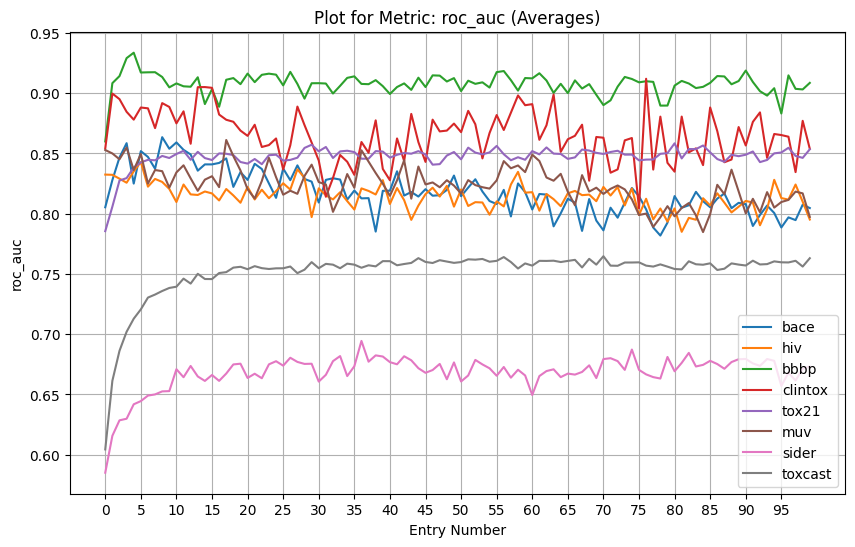

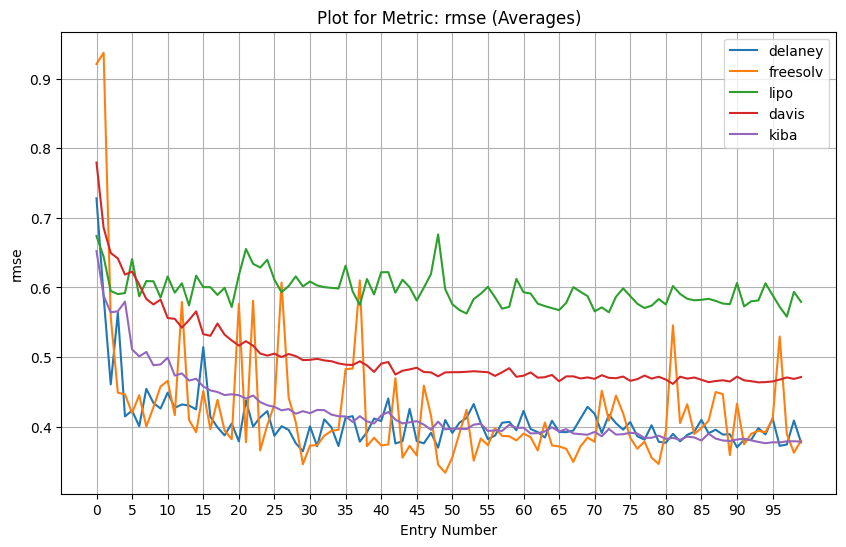

In [84]:
import matplotlib.pyplot as plt
# Function to extract data by metric and compute averages
def extract_averages_by_metric(nested_dict):
    metrics = {}
    for task_name, records in nested_dict.items():
        for record in records:
            for metric, value in record.items():
                if metric not in metrics:
                    metrics[metric] = {}
                if task_name not in metrics[metric]:
                    metrics[metric][task_name] = []
                # Compute average if value is an array, or use the scalar value directly
                if isinstance(value, np.ndarray):
                    metrics[metric][task_name].append(value.mean())
                else:
                    metrics[metric][task_name].append(value)
    return metrics

# Extract data grouped by metric with averages
metrics_data = extract_averages_by_metric(eval_metrics)

# Plot data for each metric
for metric, tasks in metrics_data.items():
    plt.figure(figsize=(10, 6))
    for task_name, values in tasks.items():
        # Plot averages for this task
        plt.plot(range(len(values)), values, label=task_name)

    # Customize the plot
    plt.title(f"Plot for Metric: {metric} (Averages)")
    plt.xlabel("Entry Number")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    # Set x-axis ticks every 5 entries
    max_entries = max(len(values) for values in tasks.values())
    plt.xticks(ticks=range(0, max_entries, 5))

    # Show the plot
    plt.show()

In [85]:
import numpy as np

# Compute the highest average or minimum values based on task type, including epoch
highest_scores = {}

for task_name, results in eval_metrics.items():
    if task_name in ["lipo", "delaney", "freesolv", "kiba","davis"]:  # These use 'mse'
        comparison_func = np.min
        metric_key = 'min_value'
    else:  # All other tasks use 'roc_auc'
        comparison_func = np.mean
        metric_key = 'highest_avg'
    
    best_metric = float('inf') if metric_key == 'min_value' else float('-inf')
    best_result = None
    best_epoch = None
    
    for entry_id, result in enumerate(results):
        for metric_type, values in result.items():
            values = np.array(values)  # Ensure values are NumPy arrays
            metric = comparison_func(values)  # Compute min or mean
            
            if (metric_key == 'min_value' and metric < best_metric) or \
               (metric_key == 'highest_avg' and metric > best_metric):
                best_metric = metric
                best_result = values
                best_epoch = entry_id // 11  # Calculate the epoch
    
    # Store the best metric, original values, and epoch
    highest_scores[task_name] = {
        metric_key: best_metric,
        'original_values': best_result.tolist(),  # Convert back to list for output
        'epoch': best_epoch
    }

# Output the results
for task_name, info in highest_scores.items():
    metric_key = 'min_value' if task_name in ["lipo", "delaney", "freesolv",'kiba','davis'] else 'highest_avg'
    print(f"{task_name}:")
    print(f"  {metric_key.capitalize().replace('_', ' ')}: {info[metric_key]}")
    print(f"  Original Values: {info['original_values']}")
    print(f"  Epoch: {info['epoch']}")


bace:
  Highest avg: 0.8635485287659201
  Original Values: 0.8635485287659201
  Epoch: 0
hiv:
  Highest avg: 0.8429510042275923
  Original Values: 0.8429510042275923
  Epoch: 0
bbbp:
  Highest avg: 0.9336605235042734
  Original Values: 0.9336605235042734
  Epoch: 0
clintox:
  Highest avg: 0.912042344445023
  Original Values: [0.9118907942238267, 0.9121938946662194]
  Epoch: 6
tox21:
  Highest avg: 0.8584448814772343
  Original Values: [0.8276764843384758, 0.9132078559738134, 0.884944934167732, 0.8772968197879859, 0.7050320294239367, 0.8129166666666667, 0.9182389258267852, 0.8259721388126287, 0.9022575112045592, 0.8434456723930408, 0.913403749050449, 0.8769457900807383]
  Epoch: 7
muv:
  Highest avg: 0.8612205942785028
  Original Values: [0.773274094326726, 0.9591635708656986, 0.6399630127774042, 0.9965870307167236, 0.9737396153408444, 0.753596704954171, 0.7715394271368253, 0.9456850430332635, 0.9295446992356264, 0.8517428827617126, 0.8361045130641329, 0.7468386876281614, 0.887360782990

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Function to extract data by metric and compute averages
def extract_averages_by_metric(nested_dict):
    metrics = {}
    for task_name, records in nested_dict.items():
        for record in records:
            for metric, value in record.items():
                if metric not in metrics:
                    metrics[metric] = {}
                if task_name not in metrics[metric]:
                    metrics[metric][task_name] = []
                # Compute average if value is an array, or use the scalar value directly
                if isinstance(value, np.ndarray):
                    metrics[metric][task_name].append(value.mean())
                else:
                    metrics[metric][task_name].append(value)
    return metrics

# Extract data grouped by metric with averages
metrics_data = extract_averages_by_metric(eval_metrics)

# Find best scores for each metric and task
best_scores = {}
for task_name, records in eval_metrics.items():
    for record_id, record in enumerate(records):
        for metric, value in record.items():
            if task_name not in best_scores:
                best_scores[task_name] = {}
            if metric not in best_scores[task_name]:
                best_scores[task_name][metric] = {"best_value": None, "entry_id": None}
            if isinstance(value, np.ndarray):
                score = value.mean()
            else:
                score = value
            # Update the best score if this is the highest (or lowest for MSE)
            if (
                best_scores[task_name][metric]["best_value"] is None or
                (metric == "rmse" and score < best_scores[task_name][metric]["best_value"]) or
                (metric != "rmse" and score > best_scores[task_name][metric]["best_value"])
            ):
                best_scores[task_name][metric] = {"best_value": score, "entry_id": record_id}

# Define A4 size in inches
a4_size = ( 17.69,8.27)  # A4 in inches (width, height)

# List of colors to cycle through manually
color_list = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Plot data for each metric and mark the best scores
for metric, tasks in metrics_data.items():
    plt.figure(figsize=a4_size)  # Set figure size to A4

    for i, (task_name, values) in enumerate(tasks.items()):
        color = color_list[i % len(color_list)]  # Cycle through the predefined colors
        # Plot averages for this task
        plt.plot(range(len(values)), values, label=f"{task_name} (avg)", color=color)

        # Overlay the best score if available
        if task_name in best_scores and metric in best_scores[task_name]:
            best_entry = best_scores[task_name][metric]
            best_value = best_entry["best_value"]
            best_id = best_entry["entry_id"]
            best_epoch = best_id  # Corrected epoch position for plotting

            # Mark the best point on the plot
            plt.scatter(best_epoch, best_value, color=color, s=100, zorder=5, label=f"{task_name} (best)")
            plt.annotate(f"Best: {best_value:.3f}", 
                         (best_epoch, best_value), 
                         textcoords="offset points", 
                         xytext=(0, 10), ha="center", color=color)

    # Customize the plot
    plt.title(f"Plot for Metric: {metric} (Averages with Best Values)")
    plt.xlabel("Entry Number")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    # Set x-axis ticks every 11 entries
    max_entries = max(len(values) for values in tasks.values())
    plt.xticks(ticks=range(0, max_entries , 11))
    # Save the plot
    filename = f"{metric}_plot_with_best_values_{notebook_name}.pdf"
    save_path = os.path.join("result_graphs", filename)
    plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
    print(f"Plot saved as {save_path}")
    plt.close()  # Close the figure to free memory


Plot saved as result_graphs\roc_auc_plot_with_best_values_MegaMLT-Copy10.pdf
Plot saved as result_graphs\rmse_plot_with_best_values_MegaMLT-Copy10.pdf


In [97]:
for dataset_type in metrics_data.keys():
    for dataset_name in metrics_data[dataset_type]:
        print(dataset_name, metrics_data[dataset_type][dataset_name][99])

bace 0.8046991655687308
hiv 0.7951789052907692
bbbp 0.9086204594017093
clintox 0.8538979610033219
tox21 0.8534984005983334
muv 0.797309149777428
sider 0.673240303478967
toxcast 0.76307041752983
delaney 0.3774909973144531
freesolv 0.38020649552345276
lipo 0.5792871117591858
davis 0.4713437557220459
kiba 0.3786269724369049


In [98]:
metrics_data

{'roc_auc': {'bace': [np.float64(0.8053579270970574),
   np.float64(0.8279534475186648),
   np.float64(0.8466842336407554),
   np.float64(0.8585638998682477),
   np.float64(0.8250109793588054),
   np.float64(0.8519543258673693),
   np.float64(0.8471453667105842),
   np.float64(0.8373298199385155),
   np.float64(0.8635485287659201),
   np.float64(0.8539306104523494),
   np.float64(0.8592007026789636),
   np.float64(0.8530303030303029),
   np.float64(0.8491655687307861),
   np.float64(0.8357487922705313),
   np.float64(0.8409530083443126),
   np.float64(0.8409530083443127),
   np.float64(0.8421607378129118),
   np.float64(0.8459156785243742),
   np.float64(0.8222661396574439),
   np.float64(0.8345191040843215),
   np.float64(0.8280412823891085),
   np.float64(0.8414580588493633),
   np.float64(0.8371102327624066),
   np.float64(0.8251207729468598),
   np.float64(0.813175230566535),
   np.float64(0.8375274483970137),
   np.float64(0.8278216952129995),
   np.float64(0.8401405357927096),
  

In [99]:
import os
import torch

# Define save directory
save_dir = "my_trained_model"
os.makedirs(save_dir, exist_ok=True)

# Save model weights and config
trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)  # If using a tokenizer

print(f"Model saved to {save_dir}")

Model saved to my_trained_model


In [101]:
optimizer_state = {
    "step": 100,  # Save training step
    "optimizer": trainer.optimizer.param_groups,  # Save optimizer params
}

torch.save(optimizer_state, os.path.join(save_dir, "optimizer_state.pt"))

print("Optimizer state saved.")

Optimizer state saved.


In [104]:
import os
from datasets import DatasetDict

# Define save paths
save_dir = "my_trained_model"
inputdata_dir = os.path.join(save_dir, "inputdata")

# Create directories
os.makedirs(inputdata_dir, exist_ok=True)

# Save train and test datasets
for split in ["train", "test"]:
    dataset_dict = DatasetDict(updated_datasets[split])  # Convert dict to DatasetDict
    dataset_dict.save_to_disk(os.path.join(inputdata_dir, f"{split}_datasets"))

# Save tasks dictionary separately
import json

tasks_path = os.path.join(inputdata_dir, "tasks.json")
with open(tasks_path, "w") as f:
    json.dump(updated_datasets["tasks"], f)

print(f"Processed datasets and tasks saved to {inputdata_dir}")

Saving the dataset (0/1 shards):   0%|          | 0/1210 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/32902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1631 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1187 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6265 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/74470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1141 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6862 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/513 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3360 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25046 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/98545 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/303 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8225 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/408 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/293 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1566 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18617 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/286 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1715 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/226 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/129 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/840 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5010 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/19709 [00:00<?, ? examples/s]

Processed datasets and tasks saved to my_trained_model\inputdata


In [105]:
from datasets import load_from_disk

# Load train and test datasets
train_datasets = load_from_disk(os.path.join(inputdata_dir, "train_datasets"))
test_datasets = load_from_disk(os.path.join(inputdata_dir, "test_datasets"))

# Load tasks dictionary
with open(os.path.join(inputdata_dir, "tasks.json"), "r") as f:
    tasks = json.load(f)

print("Datasets and tasks successfully loaded.")

Datasets and tasks successfully loaded.


In [108]:
train_datasets

DatasetDict({
    bace: Dataset({
        features: ['labels', 'weights', 'input_ids', 'attention_mask'],
        num_rows: 1210
    })
    hiv: Dataset({
        features: ['labels', 'weights', 'input_ids', 'attention_mask'],
        num_rows: 32902
    })
    bbbp: Dataset({
        features: ['labels', 'weights', 'input_ids', 'attention_mask'],
        num_rows: 1631
    })
    clintox: Dataset({
        features: ['labels', 'weights', 'input_ids', 'attention_mask'],
        num_rows: 1187
    })
    tox21: Dataset({
        features: ['labels', 'weights', 'input_ids', 'attention_mask'],
        num_rows: 6265
    })
    muv: Dataset({
        features: ['labels', 'weights', 'input_ids', 'attention_mask'],
        num_rows: 74470
    })
    sider: Dataset({
        features: ['labels', 'weights', 'input_ids', 'attention_mask'],
        num_rows: 1141
    })
    toxcast: Dataset({
        features: ['labels', 'weights', 'input_ids', 'attention_mask'],
        num_rows: 6862
    })
  

In [110]:
train_datasets['davis']['input_ids'][-1] == updated_datasets['train']['davis']['input_ids'][-1]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [ ]:
# Load model
from transformers import AutoModel

model = AutoModel.from_pretrained(save_dir)

# Load optimizer
optimizer_state = torch.load(os.path.join(save_dir, "optimizer_state.pt"))
optimizer.param_groups = optimizer_state["optimizer"]

# Load training state
training_state = torch.load(os.path.join(save_dir, "training_state.pt"))
current_epoch = training_state["epoch"]
global_step = training_state["global_step"]
last_loss = training_state["loss"]

print("Model, optimizer, and training state restored.")